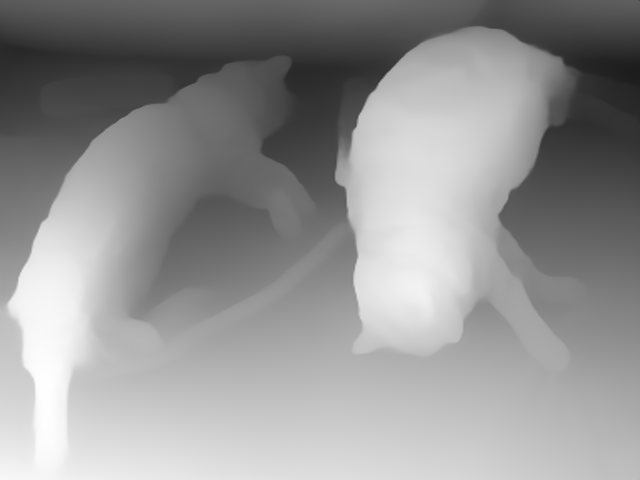

In [5]:
from PIL import Image
import numpy as np
import requests
import torch

from transformers import DPTImageProcessor, DPTForDepthEstimation

image_processor = DPTImageProcessor.from_pretrained("Intel/dpt-hybrid-midas")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=True)

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
depth.show()


-------------------
Final CorLoc:  0.8
-------------------


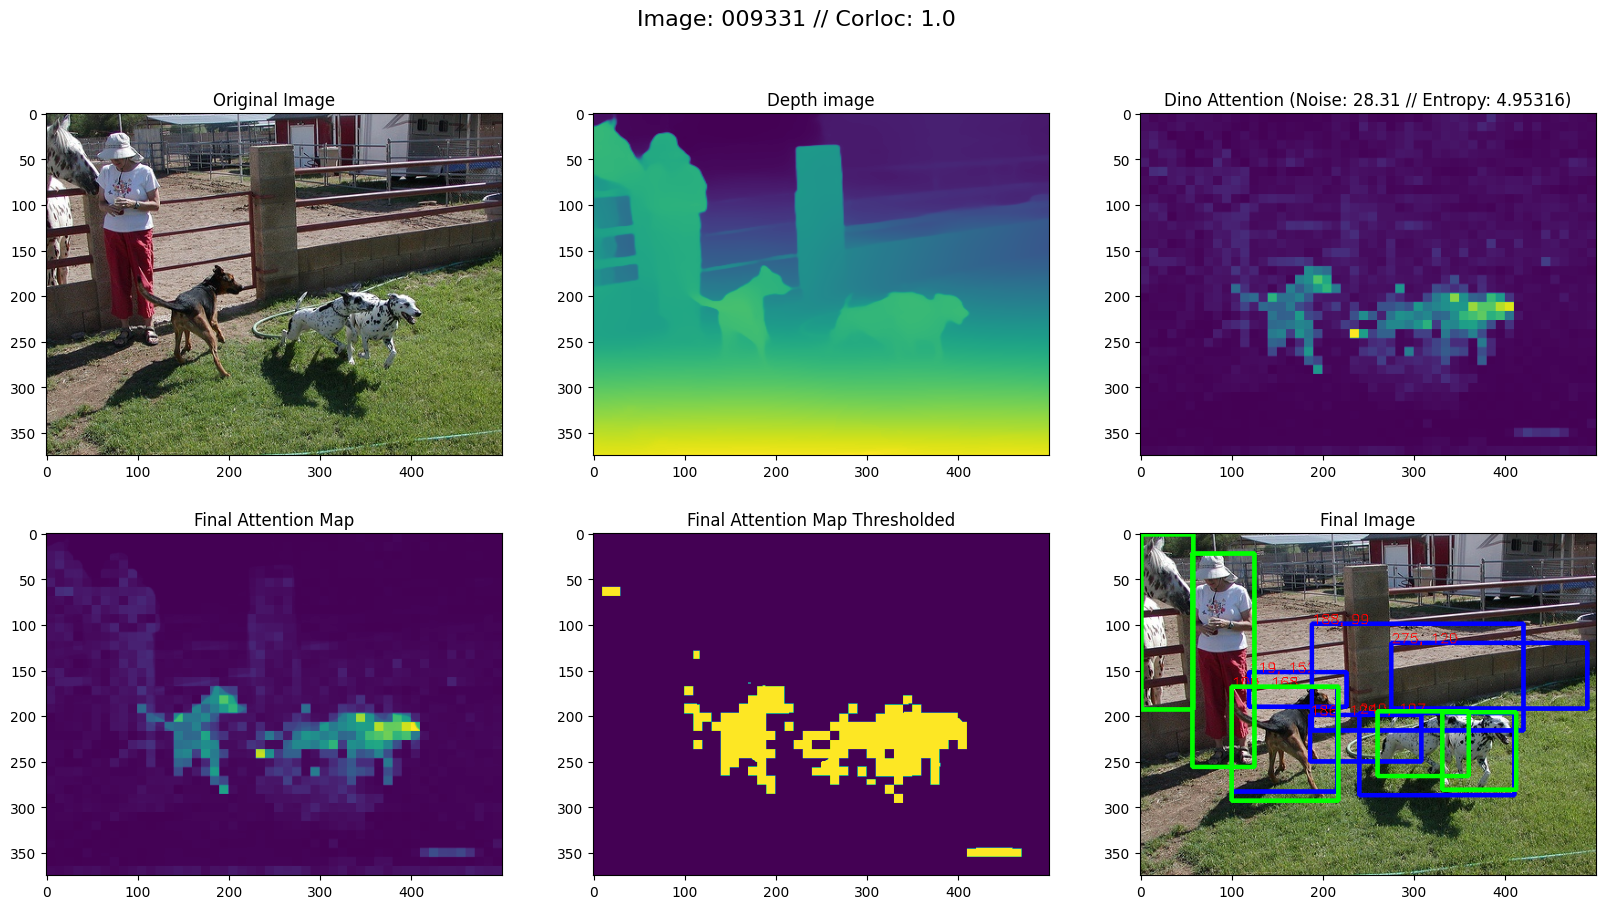

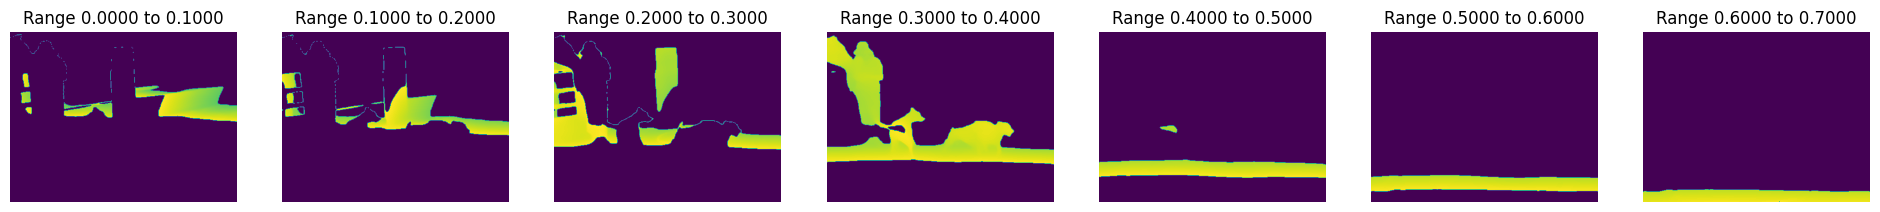

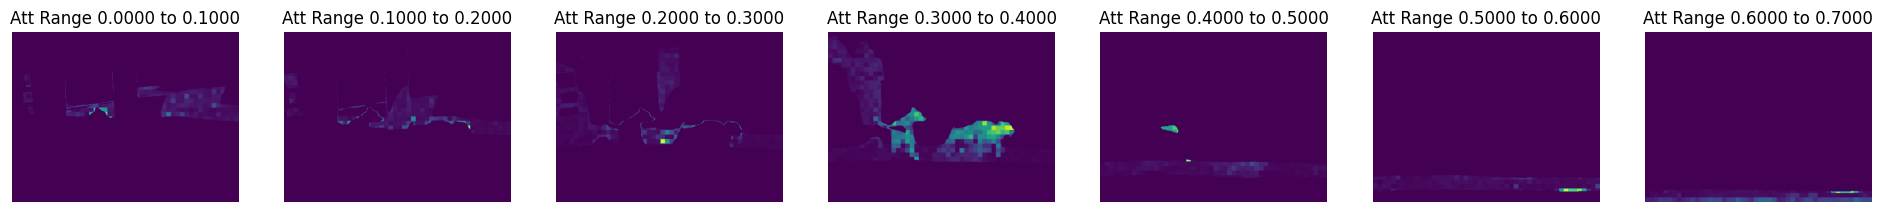

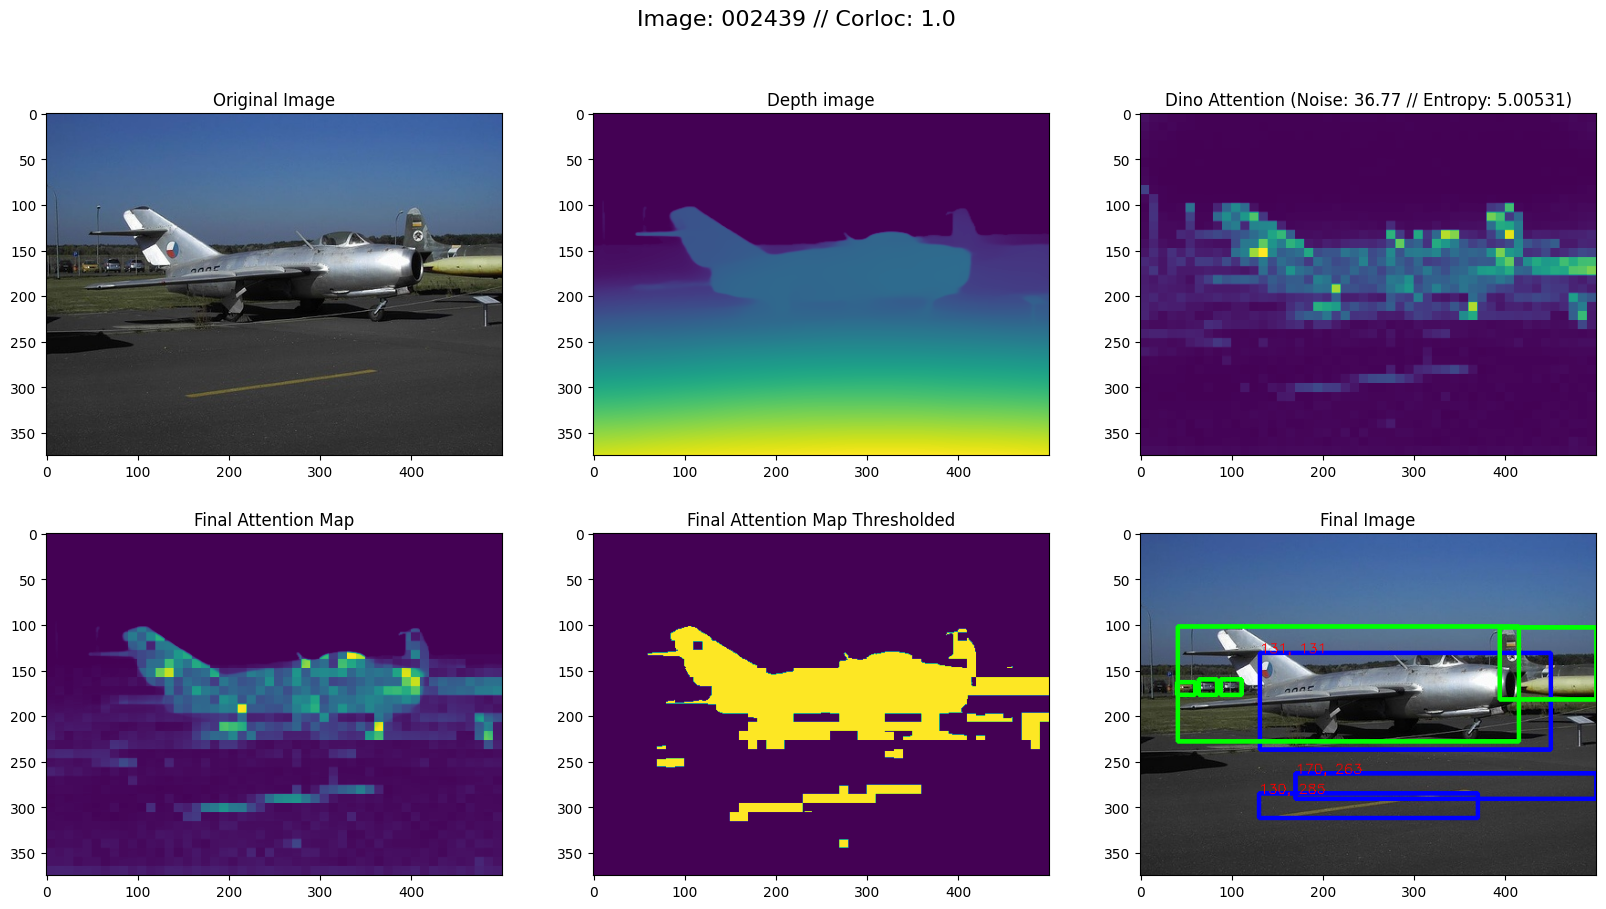

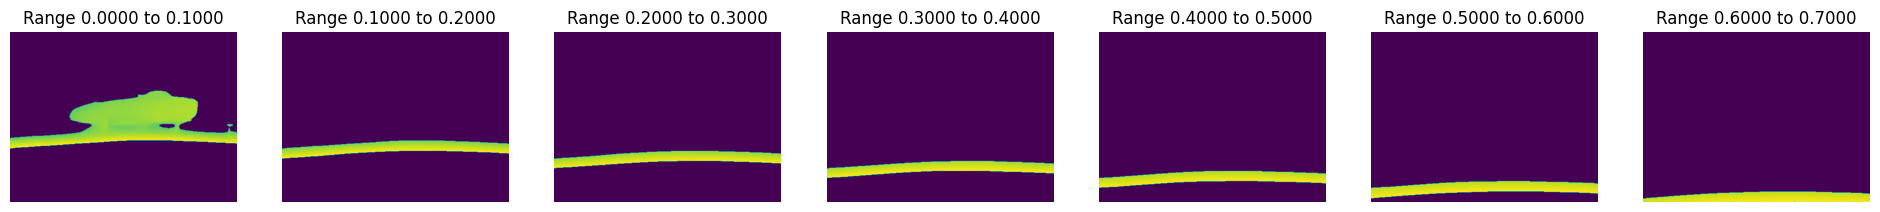

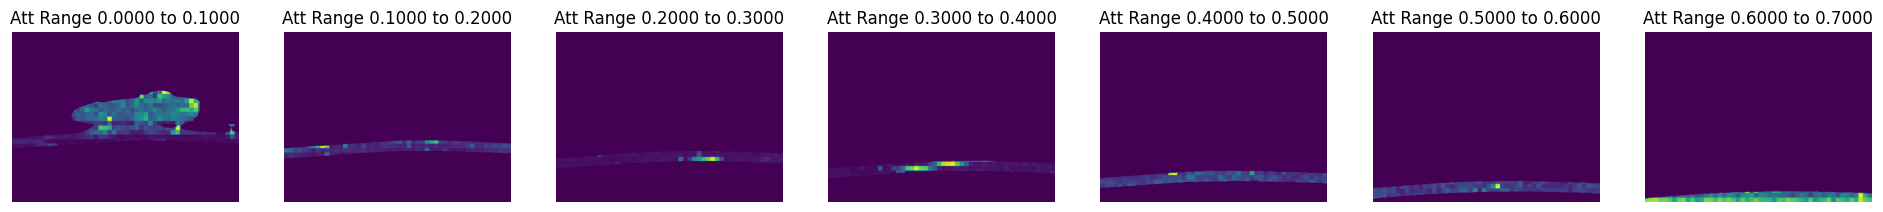

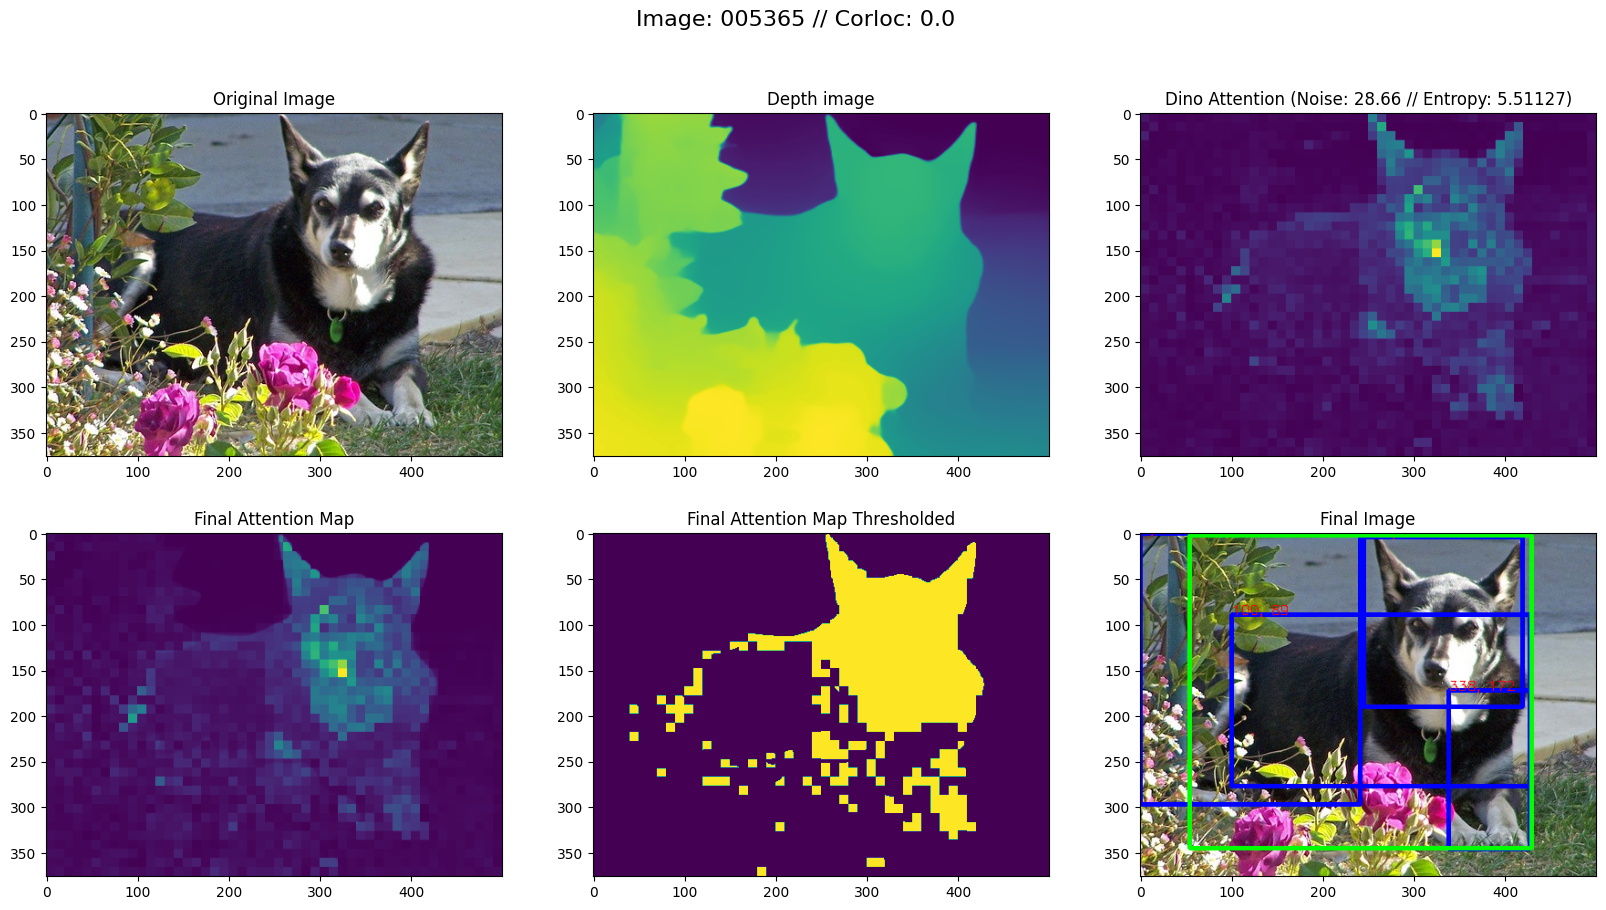

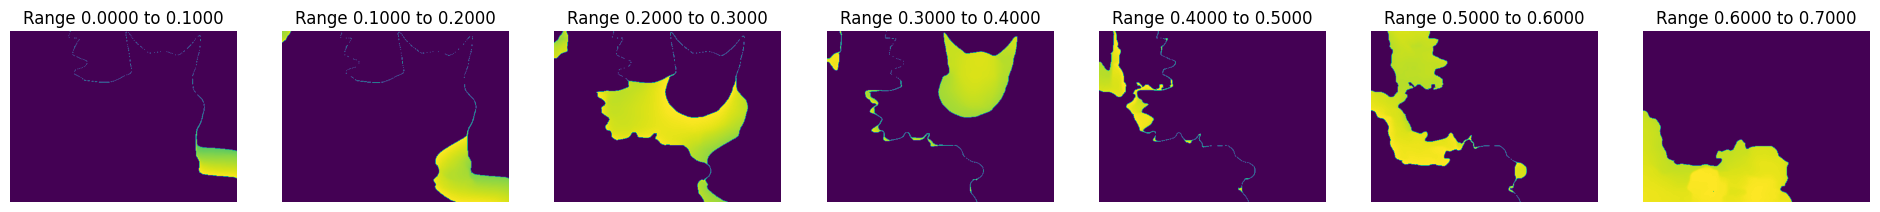

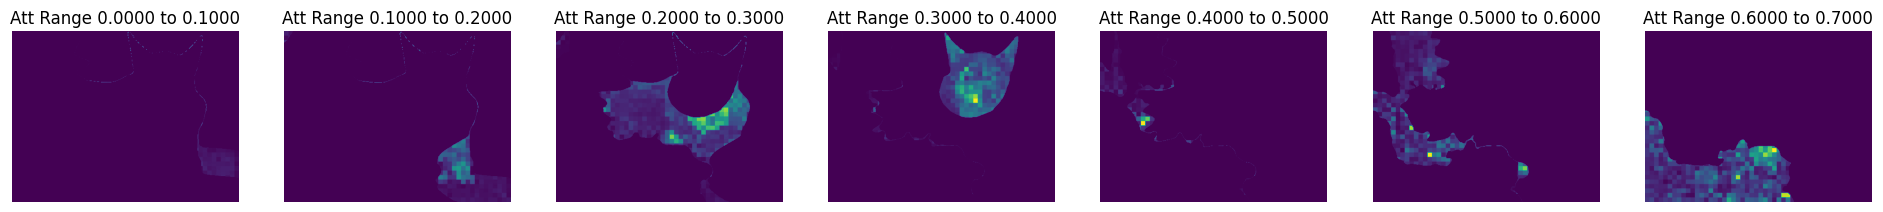

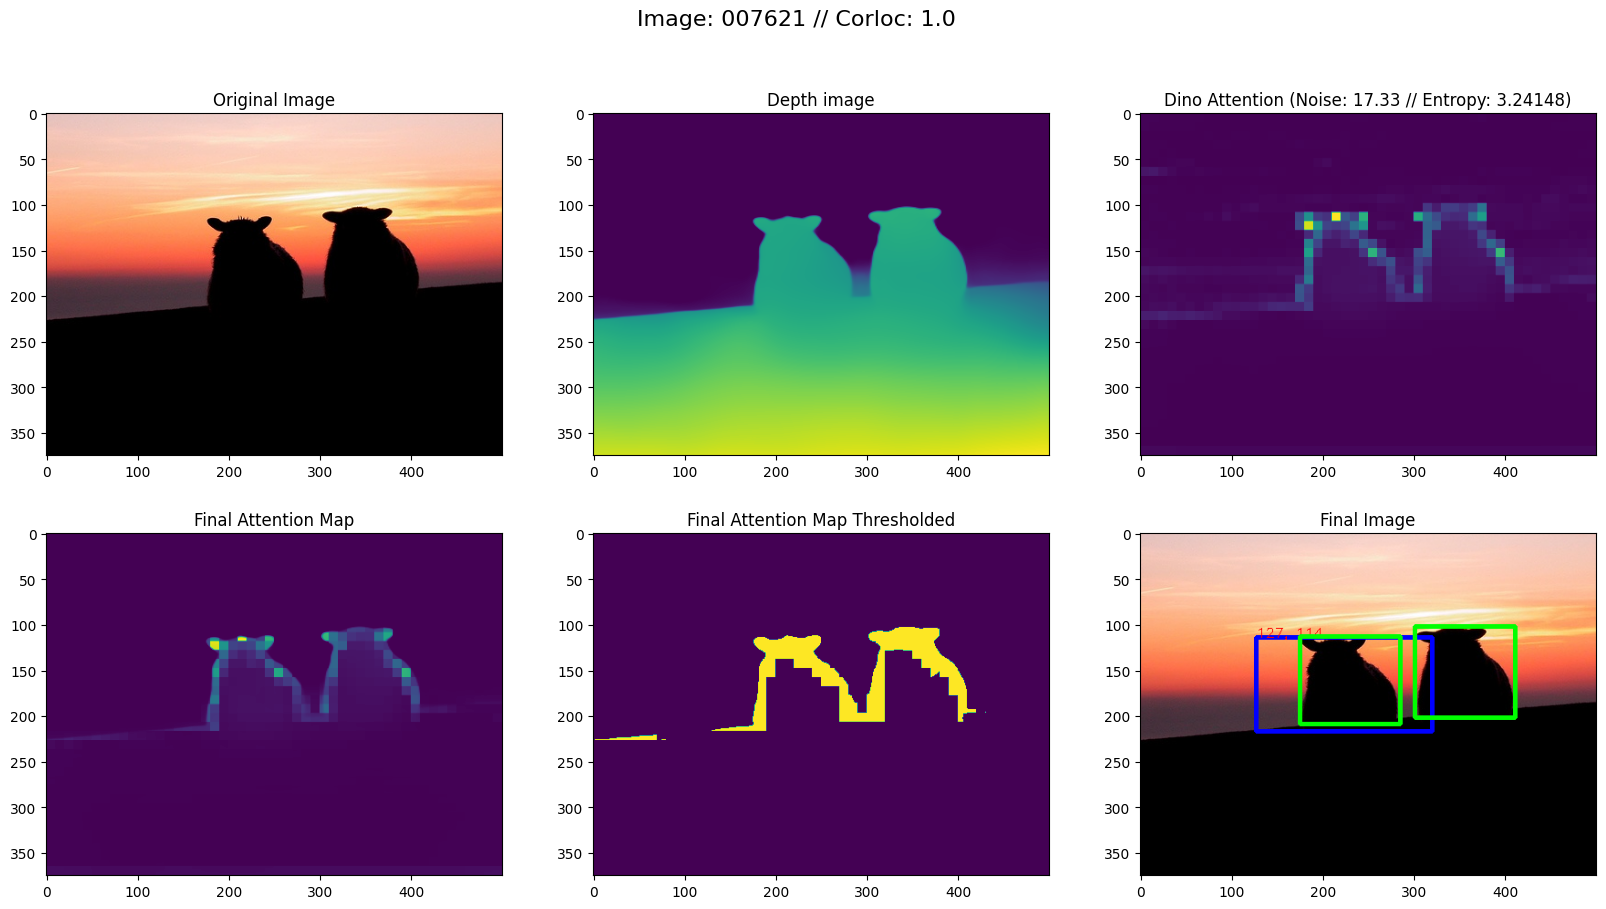

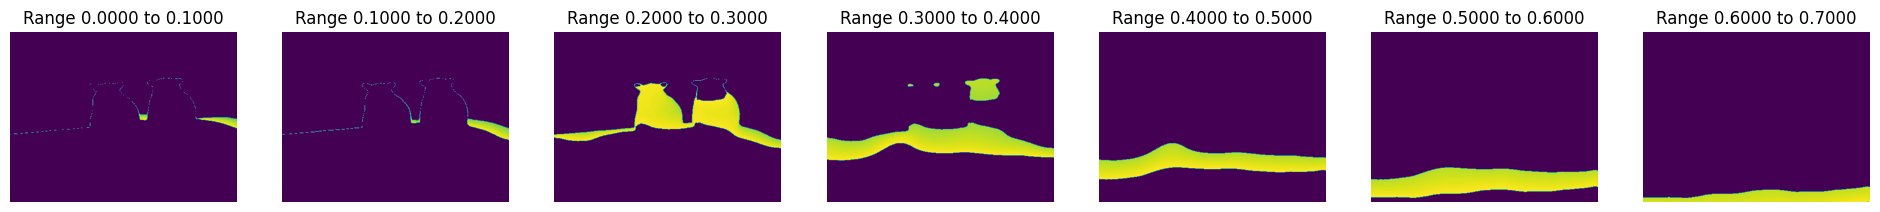

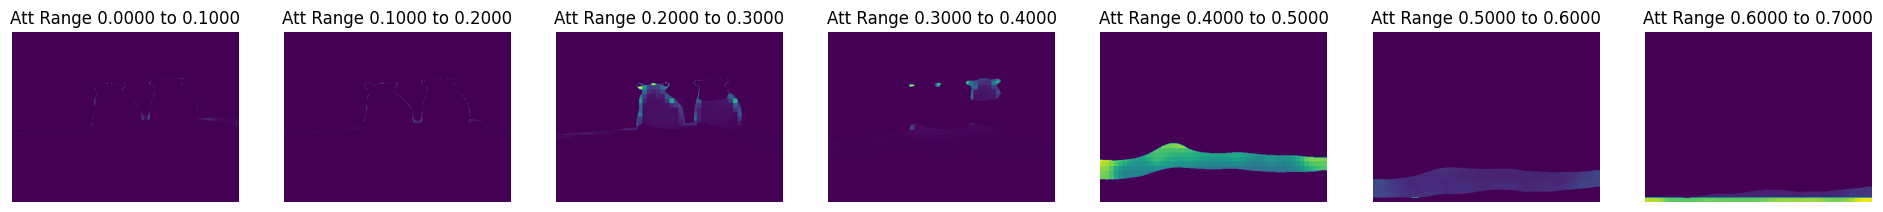

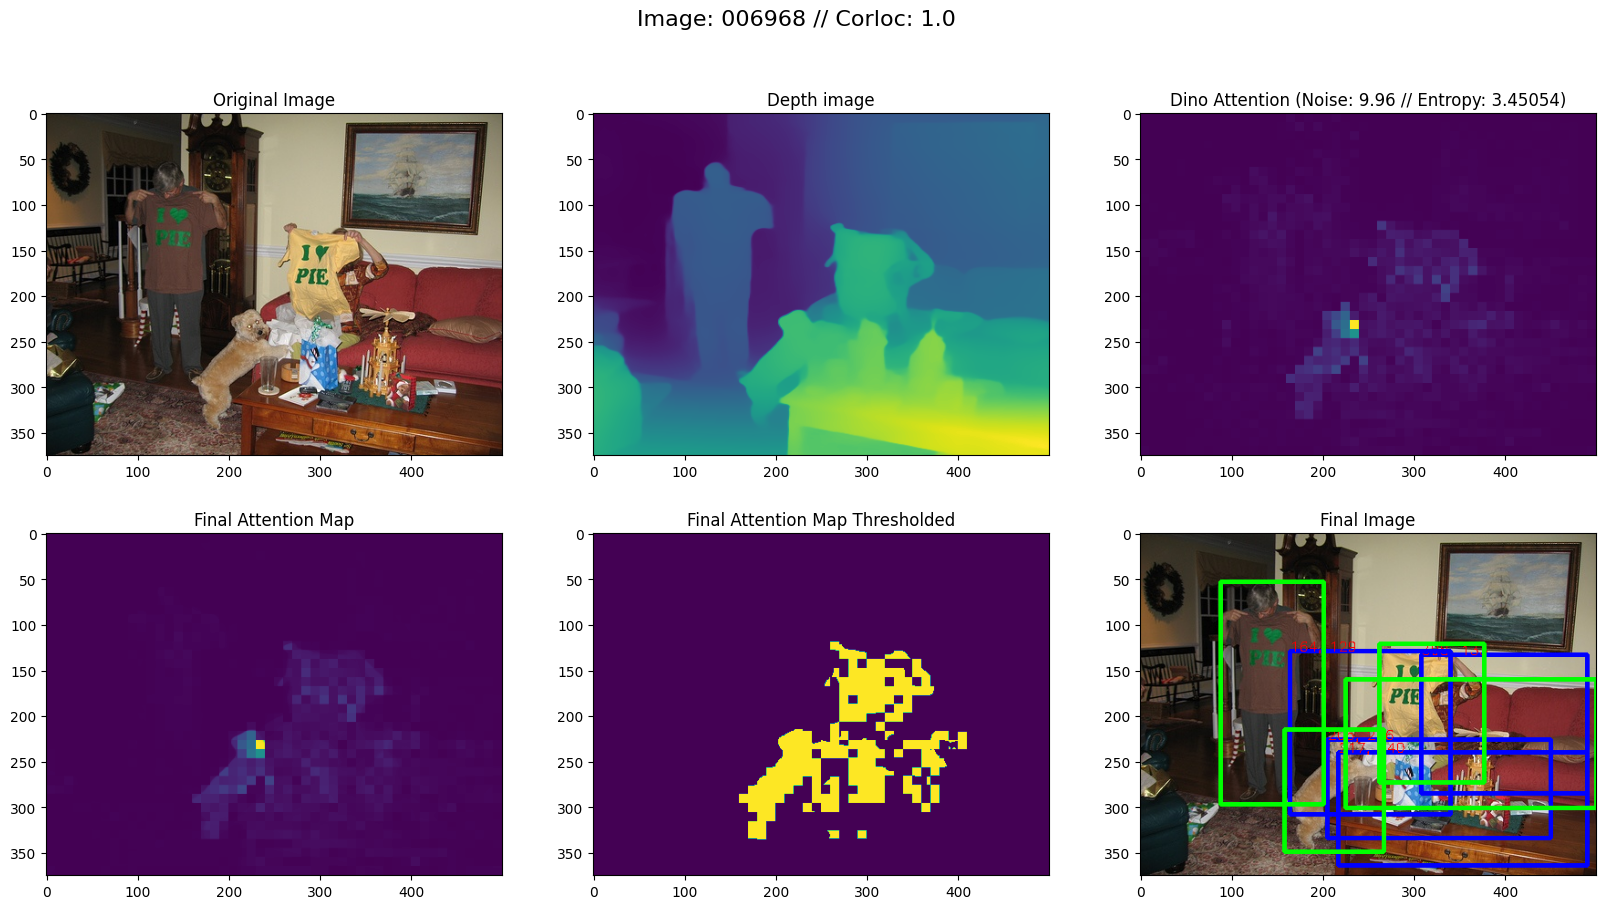

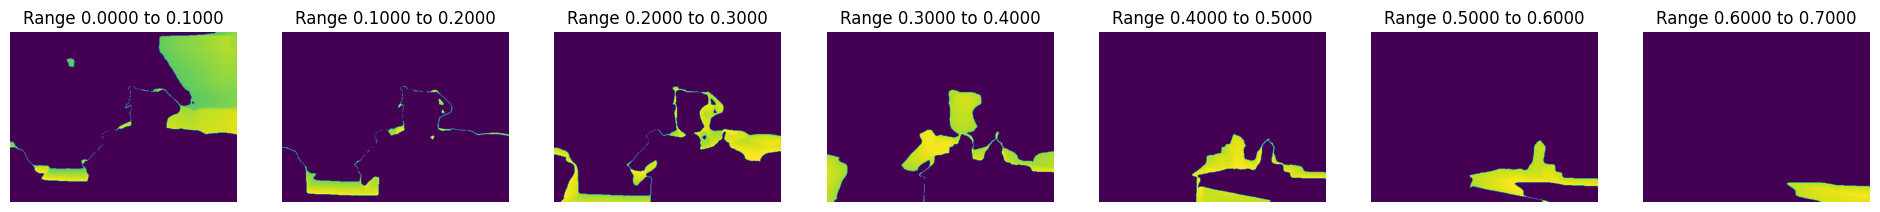

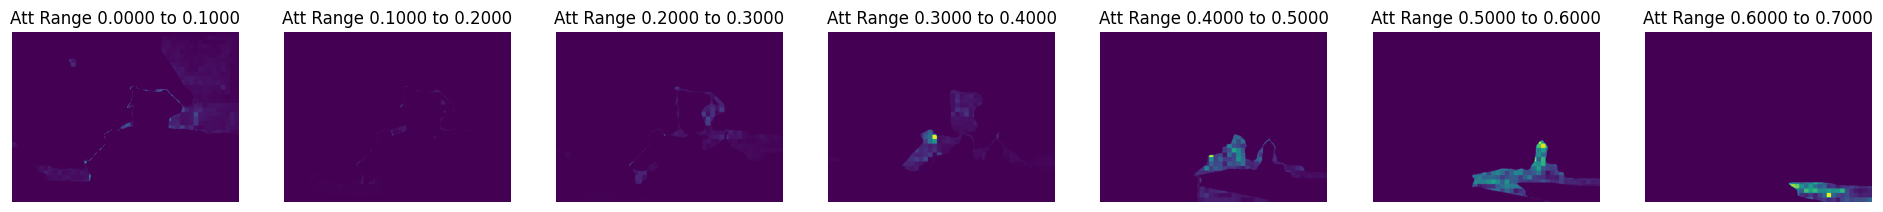

In [6]:
# 1. read an image
# 2. convert to tensor and transform
# 3. padding to prepare for dino model

# 6. pass through the model to get the depth
# 7. obtain the depth map

# 4. pass through dino model to get features
# 5. obtain the attention map

# 8. process depth (get the attention)
# 9. obtain the attention map from depth processed
# 10. process the attention map
# 11. obtain the final attention map merged from depth and dino

import torch
from torch import nn
from PIL import Image

from myutils.depth import *
from myutils.dino1 import load_dino1_model
from myutils.dino2 import load_dino2_model
from myutils.discovery import *
from myutils.pascal_voc import *
from myutils.ssl import *
from myutils.utils import *
from myutils.datasets import bbox_iou

import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

from transformers import  DPTForDepthEstimation, DPTImageProcessor

import base64
import json

# dino v1
params = {
    'patch_size': 16,
    'ssl_checkpoint': 'pretrained/dino_deitsmall16_pretrain.pth',
    'depth_checkpoint': 'Intel/dpt-hybrid-midas',
    'img_size': None
}

# dino v2
#params = {
#    'patch_size': 14,
#    'ssl_checkpoint': 'pretrained/dinov2_vits14_reg4_pretrain.pth',
#    'depth_checkpoint': 'Intel/dpt-beit-base-384',
#    'img_size': 526
#}

dataset_path = "datasets/VOC2007/VOCdevkit/VOC2007"



# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get X random images from dataset_path
#images = get_images(dataset_path, 100)

#images = ['005881', '000250', '001855', '007586', '009079', '003159', '009745', '004801', '004244', '006185', '002405', '000334', '008349', '007853', '001263', '007193', '008856', '003678', '008833', '000109', '002873', '009881', '007040', '007751', '008917', '003369', '003629', '004828', '004192', '008415', '008733', '009418', '006694', '005676', '006339', '001590', '004281', '008096', '009438', '006212', '005064', '008372', '009343', '001185', '009307', '003433', '002266', '009214', '009421', '007417', '000951', '004359', '005732', '007697', '001981', '003147', '002224', '003051', '004706', '000047', '001393', '001510', '002977', '003994', '002880', '005790', '006247', '006282', '004441', '006822', '006626', '007398', '007261', '009246', '007503', '001343', '001250', '003807', '000667', '003120', '000489', '007372', '001455', '000470', '004797', '005101', '000917', '005312', '007847', '009904', '006425', '000483', '001927', '009331', '004518', '000173', '002439', '005365', '007621', '006968']
images = ['009331', '002439', '005365', '007621', '006968']

corloc = np.zeros(len(images))

for i, img_name in enumerate(images):

    image_path = f'{dataset_path}/JPEGImages/{img_name}.jpg'
    annotation_path = f'{dataset_path}/Annotations/{img_name}.xml'


    ##############
    # WARMING UP #
    ##############

    # Read an image
    pil_img = load_image_as_pil(image_path)

    # Convert to tensor and transform
    img_tensor = load_image_as_tensor(pil_img).to(device)

    # Get the ground truth
    ground_truth, ground_truth_img = get_ground_truth_voc2007(annotation_path, pil_img)

    #plt.imshow(ground_truth_img)
    #plt.show()

    #########################
    # GETTING THE ATTENTION #
    #########################

    # Padding the image with zeros to fit multiple of patch-size
    patch_size = params['patch_size']
    img_paded = img_tensor_padded(img_tensor, patch_size).to(device)

    # Load the SSL model
    model = load_dino1_model(patch_size, params['ssl_checkpoint'], device, params['img_size'])
    #model = load_dino2_model(patch_size, params['ssl_checkpoint'], device, params['img_size'])
    model.to(device)
    model.eval()

    # Get the attentions
    atts = get_attentions(model, img_paded, patch_size)

    # Obtain the attention map

    # Sum the attention outputs (6 outputs used in DINO)
    sum_atts = atts.sum(0)

    noise = estimate_noise(sum_atts)
    entropy = calculate_entropy(sum_atts)

    # Resize the attentions to the original image size
    sum_atts_resized = cv2.resize(sum_atts, (pil_img.width, pil_img.height))

    #plt.imshow(sum_atts_resized)
    #plt.show()

    # Normalize sum_atts_resized from 0 to 1
    sum_atts_resized_norm = (sum_atts_resized - np.min(sum_atts_resized)) / (np.max(sum_atts_resized) - np.min(sum_atts_resized))

    #print("sum_atts_resized_norm", sum_atts_resized_norm.min(), sum_atts_resized_norm.max())
    #plt.imshow(sum_atts_resized_norm)
    #plt.show()


    #################
    # GETTING DEPTH #
    #################

    # Get the depth prediction
    depth_feats, depth_image = get_depth_prediction(pil_img, params['depth_checkpoint'])

    # Obtain the depth map

    # Resize depth_image to the original image size
    numpy_depth_image = depth_image.squeeze(0).cpu().numpy()
    depth_image_resized = cv2.resize(numpy_depth_image, pil_img.size)

    # plt.imshow(depth_image_resized)
    # plt.show()

    # Normalizing depth
    depth_image_resized_norm = (depth_image_resized - np.min(depth_image_resized)) / (np.max(depth_image_resized) - np.min(depth_image_resized))


    ############################
    # FINAL ATT * GLOBAL DEPTH #
    ############################

    # final attention map (depth * att)
    final_attention_map = depth_image_resized_norm * sum_atts_resized_norm

    #plt.imshow(final_attention_map)
    #plt.show()

    # Normalize final_attention_map from 0 to 255
    final_attention_map_255 = (final_attention_map - np.min(final_attention_map)) / (np.max(final_attention_map) - np.min(final_attention_map)) * 255
    final_attention_map_255 = final_attention_map_255.astype(np.uint8)


    ########################
    # THRESHOLDED & RESULT #
    ########################

    # Apply a binary threshold to the image
    _, final_att_thresholded = cv2.threshold(final_attention_map_255, final_attention_map_255.std(), 255, cv2.THRESH_BINARY)

    # Get the predicted boxes from the final image using contours
    predicted_boxes = get_boxes(final_att_thresholded)

    #plt.imshow(final_att_thresholded)
    #plt.show()


    ###################
    # DEPTH SPLITTING #
    ###################

    # Normalize the depth image from 0 to 1
    img_to_split_norm = depth_image_resized_norm.copy()

    # Define the number of intervals
    num_layers = 10

    # Compute the ranges dynamically
    ranges = [(i / num_layers, (i + 1) / num_layers) for i in range(num_layers)]

    # Create an empty list to store the depth_layers for each range
    depth_layers = []

    # Loop through each range and create the corresponding image
    for r in ranges:
        lower, upper = r
        mask = (img_to_split_norm >= lower) & (img_to_split_norm < upper)
        range_img = np.where(mask, img_to_split_norm, 0)  # Retain original values within range, set others to 0
        depth_layers.append(range_img)

    # let´s remove the background layers (num_layers / 3)
    depth_layers = depth_layers[num_layers // 3:]

    proposed_boxes = []

    for depth_layer in depth_layers:

        #normalize depth_layer
        depth_layer = (depth_layer - np.min(depth_layer)) / (np.max(depth_layer) - np.min(depth_layer))

        #resize depth_layer to att size
        depth_layer = cv2.resize(depth_layer, (sum_atts_resized_norm.shape[1], sum_atts_resized_norm.shape[0]))

        # multiply depth_layer by att
        depth_layer_atts = depth_layer * sum_atts_resized_norm

        #plt.imshow(depth_layer_atts)
        #plt.show()

        # normalize depth_layer_atts from 0 to 255
        depth_layer_atts = depth_layer_atts - np.min(depth_layer_atts)
        depth_layer_atts = depth_layer_atts / np.max(depth_layer_atts) * 255
        depth_layer_atts = depth_layer_atts.astype(np.uint8)

        # Apply a binary threshold to the image
        _, layer = cv2.threshold(depth_layer_atts, depth_layer_atts.std(), 255, cv2.THRESH_BINARY)

        #plt.imshow(layer)
        #plt.show()

        # Get the predicted boxes from the final image using contours
        layer_predicted_boxes = get_boxes(layer)

        # Append the predicted boxes to the proposed_boxes
        proposed_boxes.extend(layer_predicted_boxes)

        # Get the final image with the boxes drawn (predicted and ground truth)

        # final_image = get_output_image(pil_img, layer_predicted_boxes, ground_truth)

        #plt.imshow(final_image)
        #plt.show()


    ###############
    # FINAL BOXES #
    ###############

    # Let´s validate the proposed_boxes with predicted_boxes
    # if the IoU is greater than iou_threshold, we consider it a match

    iou_threshold = 0.1
    final_boxes = []

    for proposed_box in proposed_boxes:

        ious = bbox_iou(torch.tensor(proposed_box), torch.tensor(predicted_boxes), x1y1x2y2=False)

        for iou in ious:
            if iou > iou_threshold:
                final_boxes.append(proposed_box)

    # let´s draw the final image with the proposed_boxes matched with the predicted_boxes
    final_boxes_image = get_output_image(pil_img, final_boxes, ground_truth)

    #plt.imshow(final_boxes_image)
    #plt.show()


    #################
    # LOCAL RESULTS #
    #################

    ground_truth_as_list = convert_ground_truth_voc2007_to_list(ground_truth)
    local_corloc, ious = get_corloc_and_ious(ground_truth_as_list, final_boxes)

    # Storing image-corloc to obtain final dataset-corloc later
    corloc[i] = local_corloc




    '''


    ############################
    # FINAL ATT * GLOBAL DEPTH #
    ############################

    # final attention map (depth * att)
    final_attention_map = depth_image_resized_norm * sum_atts_resized_norm

    #plt.imshow(final_attention_map)
    #plt.show()

    # Normalize final_attention_map from 0 to 255
    final_attention_map_255 = (final_attention_map - np.min(final_attention_map)) / (np.max(final_attention_map) - np.min(final_attention_map)) * 255
    final_attention_map_255 = final_attention_map_255.astype(np.uint8)


    ########################
    # THRESHOLDED & RESULT #
    ########################

    # Apply a binary threshold to the image
    _, final_att_thresholded = cv2.threshold(final_attention_map_255, final_attention_map_255.std(), 255, cv2.THRESH_BINARY)

    # Get the predicted boxes from the final image using contours
    predicted_boxes = get_boxes(final_att_thresholded)

    #plt.imshow(final)
    #plt.show()

    # Get the final image with the boxes drawn (predicted and ground truth)

    final_image = get_output_image(pil_img, predicted_boxes, ground_truth)

    #plt.imshow(final_image)
    #plt.show()

    ground_truth_as_list = convert_ground_truth_voc2007_to_list(ground_truth)
    local_corloc, ious = get_corloc_and_ious(ground_truth_as_list, predicted_boxes)

    # Storing image-corloc to obtain final dataset-corloc later
    corloc[i] = local_corloc

    '''

    ########################
    # PLOTTING THE PROCESS #
    ########################

    # Plot 6 images in a grid of 2x3
    title = f"Image: {img_name} // Corloc: {corloc[i]}"

    plot_image_grid(
        title, 
        pil_img, 
        depth_image_resized, 
        sum_atts_resized, 
        final_attention_map, 
        final_att_thresholded, 
        final_boxes_image,
        noise,
        entropy
    )

    # Plot the depth_layers for visualization
    fig, axes = plt.subplots(1, len(depth_layers), figsize=(24, 5))
    for i, (range_img, r) in enumerate(zip(depth_layers, ranges)):
        ax = axes[i]
        ax.imshow(range_img)
        ax.set_title(f'Range {r[0]:.4f} to {r[1]:.4f}')
        ax.axis('off')

    #plt.show()

    # Plot the depth_layers for visualization
    fig, axes = plt.subplots(1, len(depth_layers), figsize=(24, 5))
    for i, (range_img, r) in enumerate(zip(depth_layers, ranges)):
        ax = axes[i]
        ax.imshow(range_img * sum_atts_resized_norm)
        ax.set_title(f'Att Range {r[0]:.4f} to {r[1]:.4f}')
        ax.axis('off')

    #plt.show()

    # plt.imshow(final_boxes_image)
    # plt.show()

    ###################
    # STORING RESULTS #
    ###################

    # encode data as base64
    ious_b64 = base64.b64encode(json.dumps(ious).encode())
    predicted_boxes_b64 = base64.b64encode(json.dumps(predicted_boxes).encode())
    ground_truth_b64 = base64.b64encode(json.dumps(ground_truth_as_list).encode())
    
    #results_file.write(f"{i},{img_name},{corloc[i]},{ious_b64},{predicted_boxes_b64},{ground_truth_b64}\n")


############################
# FINAL CORLOC CALCULATION #
############################

# Let's calculate corloc as the percentage of images with at least one IoU > 0.5
corloc = corloc.sum() / len(images)

print("-------------------")
print("Final CorLoc: ", corloc)
print("-------------------")
